<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общие-выводы:" data-toc-modified-id="Общие-выводы:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общие выводы:</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


**Описание данных**

Данные лежат в файле /datasets/taxi.csv.

Количество заказов находится в столбце `'num_orders'` (от англ. number of orders, «число заказов»).

**Цель проекта**

Построение модели, которая прогнозирует количество заказов такс на следующий час. Значение метрики `RMSE` должно быть не более 48.

**План проекта**

1. Загрузим данные и выполним их ресемплирование по одному часу.
2. Проанализируем данные.
3. Обучим разные модели с различными гиперпараметрами, сделаем  тестовую выборку размером 10% от исходных данных.
4. Проверим данные на тестовой выборке и сделаем выводы.

## Подготовка

Первоначально загрузим необходимые нам в работе библиотеки.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Теперь загрузим датасет и взглянем на данные. Сразу переведем значения столбца с датой в формат *datetime64* и вынесем их в индекс.

In [2]:
try:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('D:/learn_data/taxi.csv', index_col=[0], parse_dates=[0])

display(df.info())
display(df.describe())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим индексы на последовательность.

In [3]:
df.index.is_monotonic

True

Индексы распложены последовательно. Как мы видим, данные содержат сведения о количестве заказов такси с 00 часов 01.03.2018 до 23 часов 31.08.2018. Шаг составляет 10 минут. Необходим ресемплировать до шага в 1 час. Сделаем это, выбрав в качестве агрегатора **sum()**, поскольку нам необходимо знать общее количеств автомобилей в течение этого часа.

In [4]:
df = df.resample('1H').sum()
display(df.head())
display(df.info())
df.describe()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [5]:
df.isna().sum()

num_orders    0
dtype: int64

Пропусков не имеется.

**Вывод:**
Загруженные данные содержали сведения о количестве вызванных такси в период с 00 часов 00 минут 01.03.2018 до 23 часов 50 минут 31.08.2018. Данные выстроены последовательно, количеств такси в признаке `'num_orders'` в целочисленной форме. Шаг в данных составлял 10 минут, нами произведено ресемплирование данных по одному часу. Минимальное количество вызовов такси составляет **0** в час, максимальное **462** в час. Общее количество объектов после ресемплинга составило *4416*.

## Анализ

Для решения вопроса о том, какие именно данные нам понадобятся, давайте взглянем на график распределения количества вызвов такис по времени. Для этого также применим метод *seasonal_decompose* для выделения тренда, сезонности и шума.  

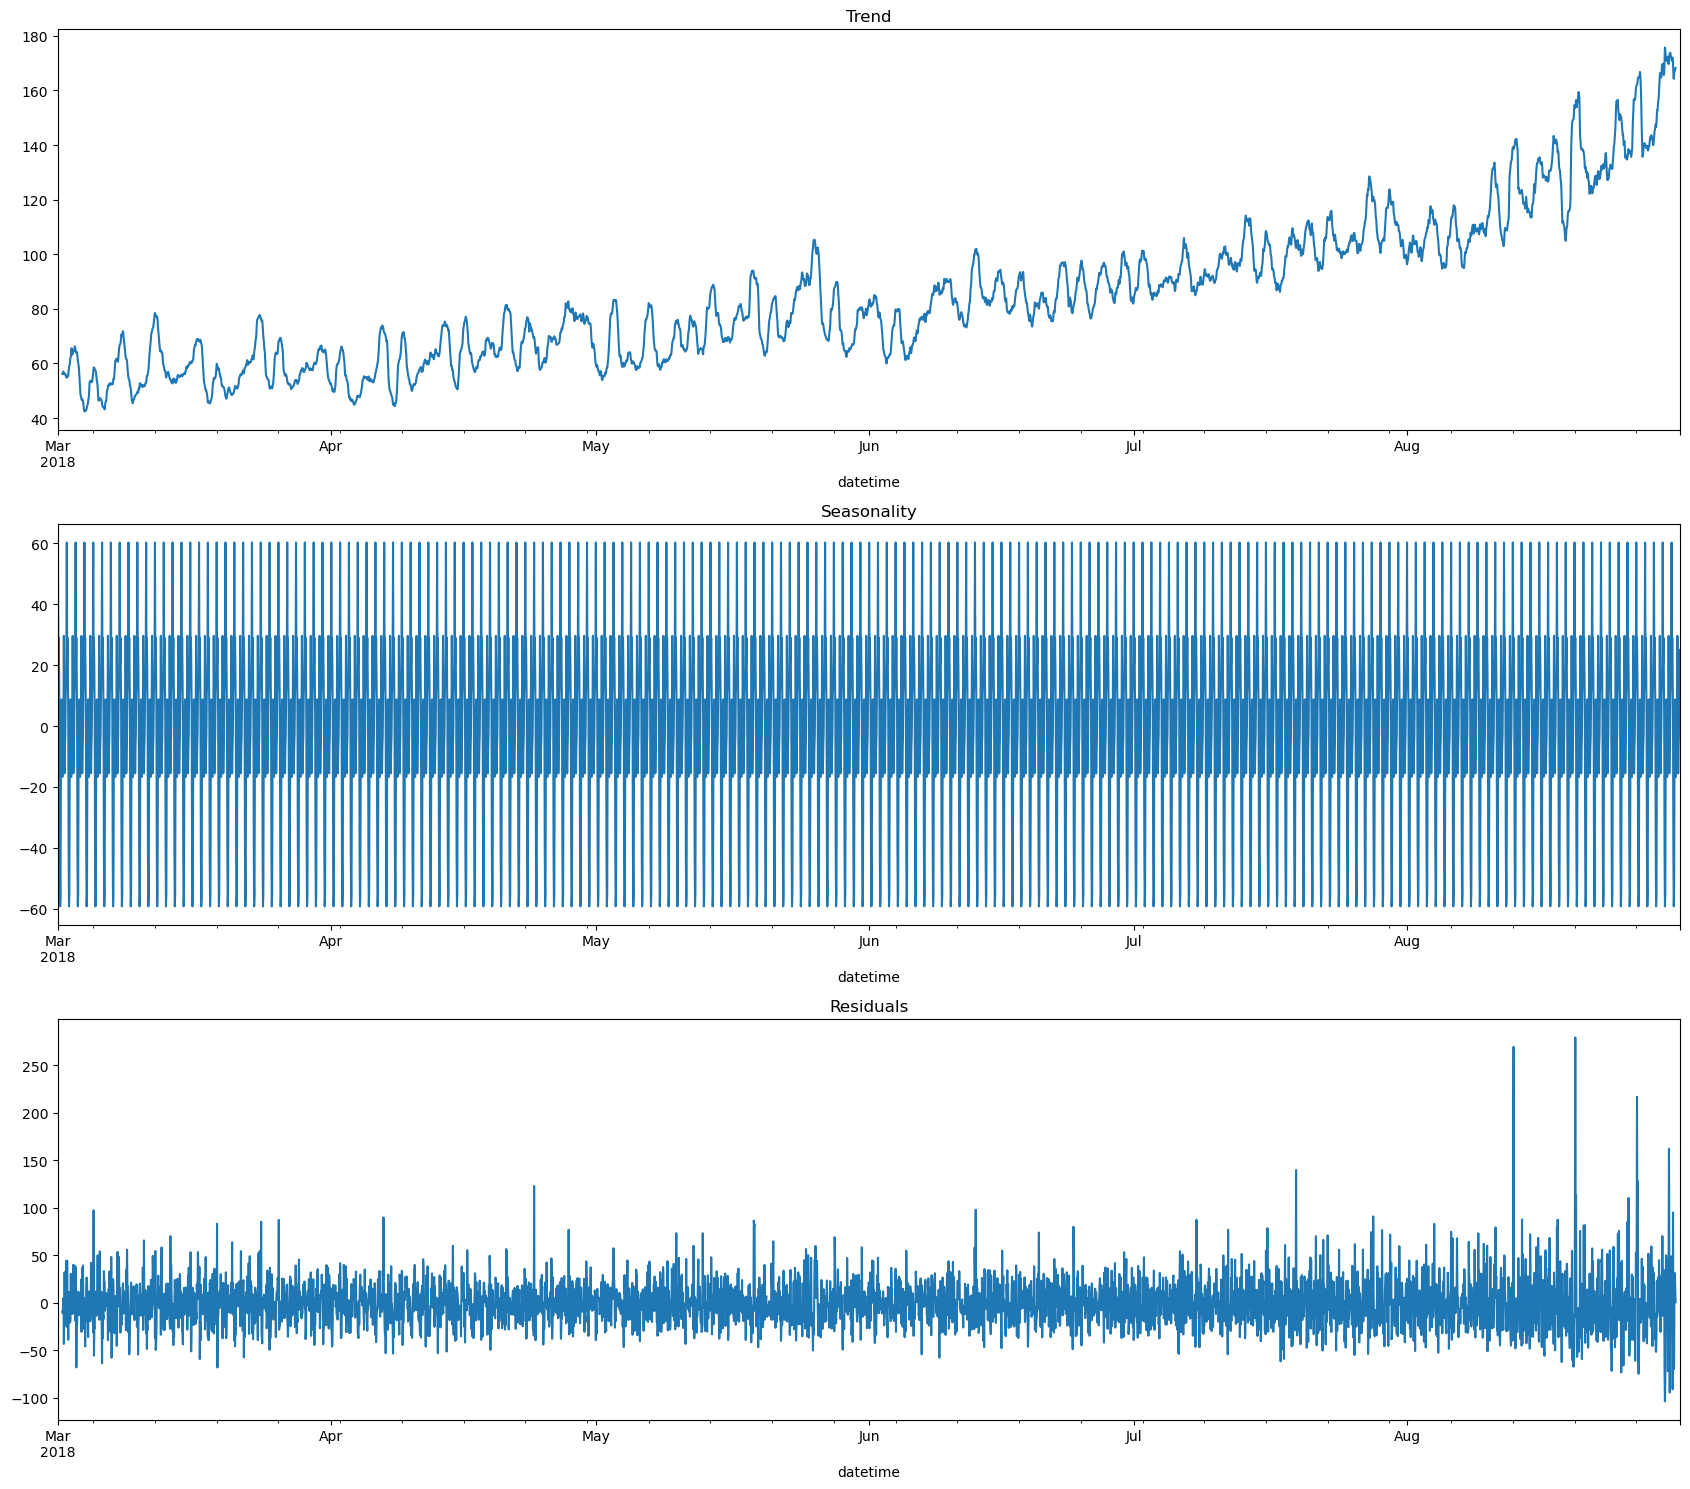

In [6]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(17, 15))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

Как мы видим, имеется тренд к увеличению количества такси со временем, также есть существенные показатели сезонности. Давайте взглянем на последний аналогичный график по последнему месяцу.

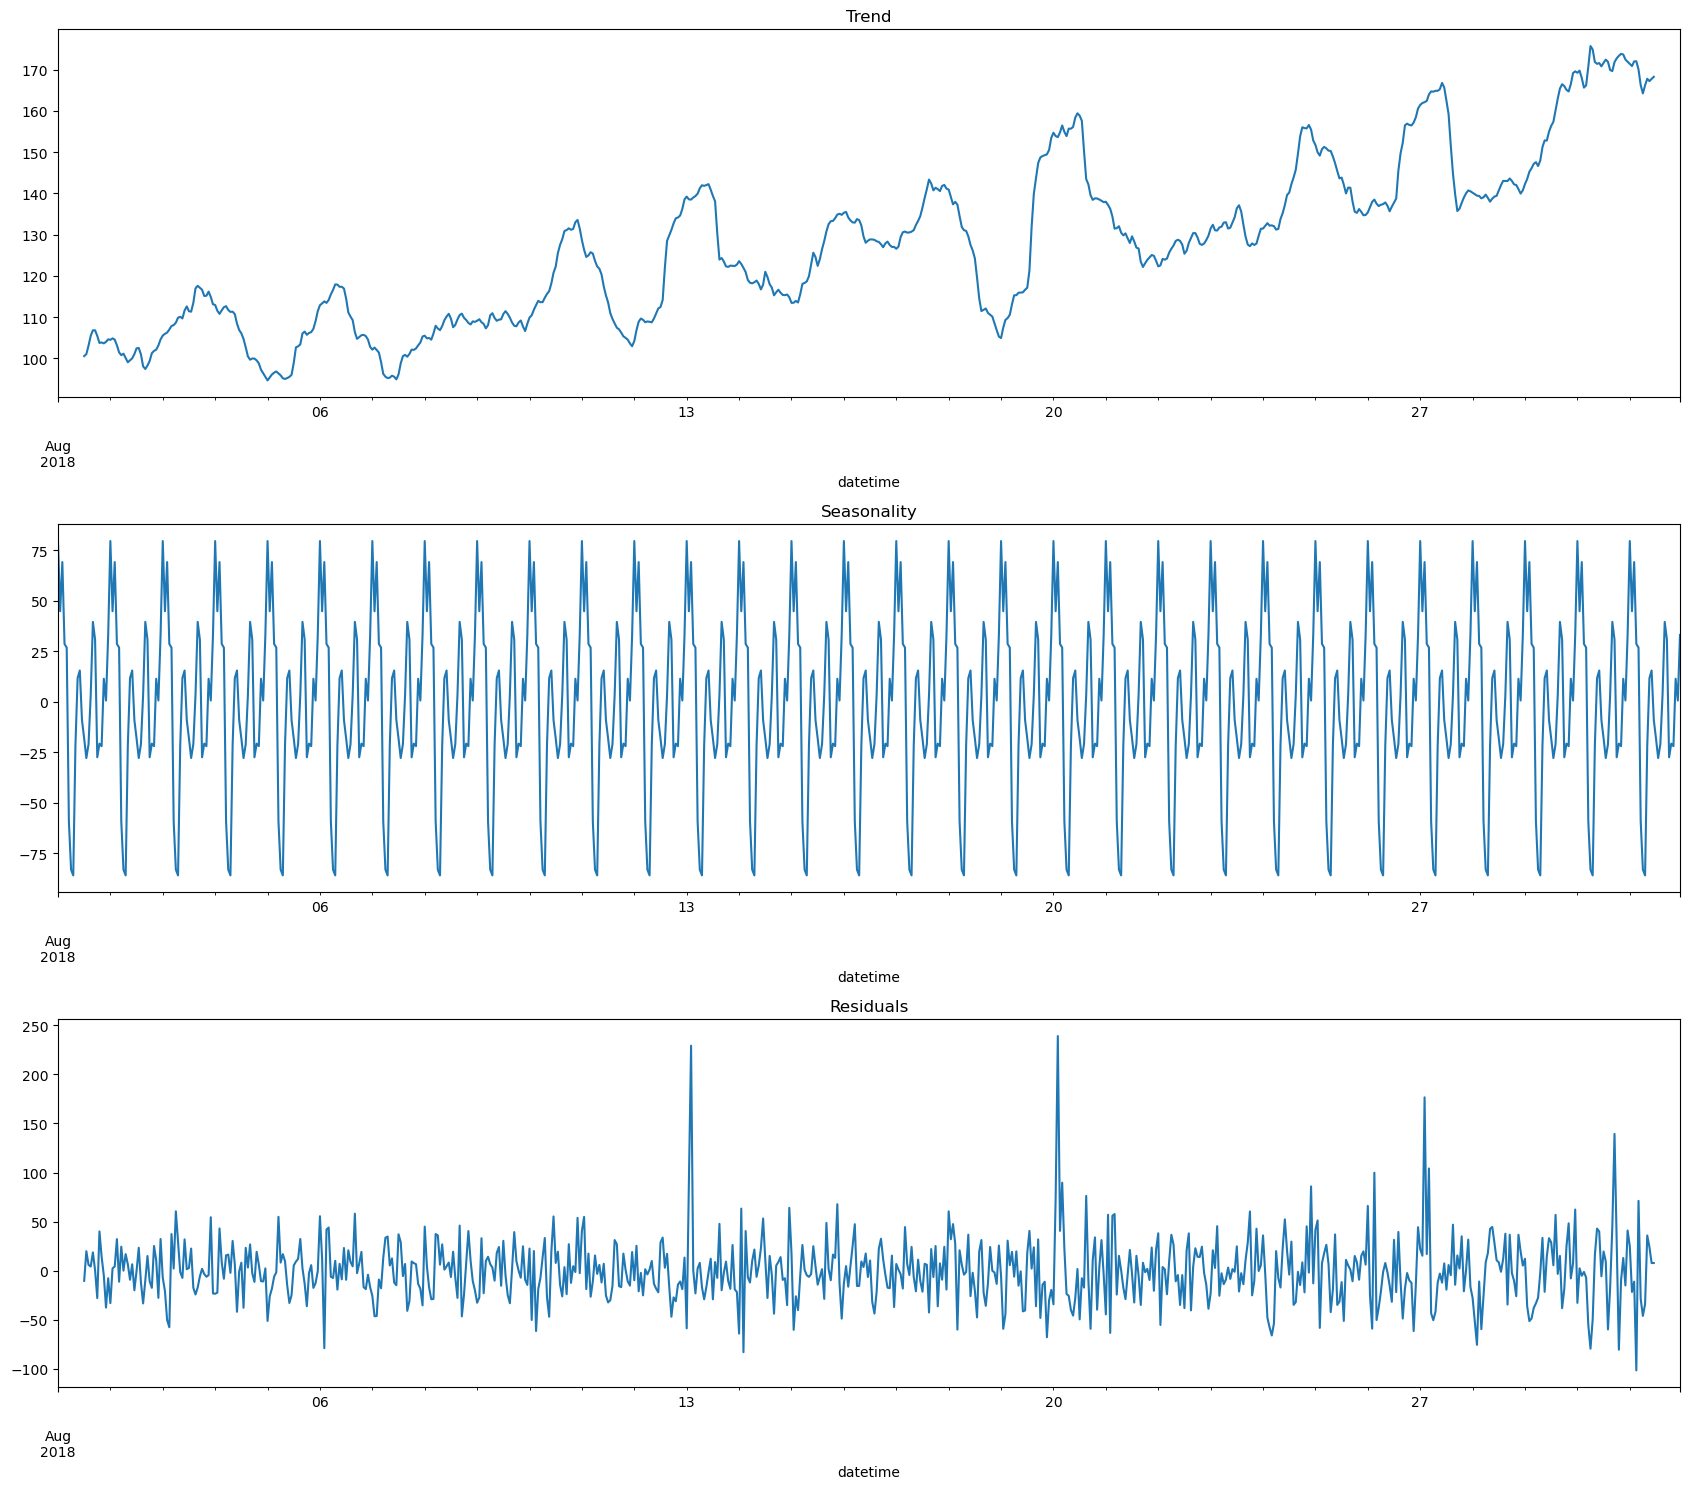

In [7]:
decomposed = seasonal_decompose(df['2018-08-01':'2018-08-31'])

plt.figure(figsize=(17, 15))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

Тренд к увеличению также сохраняется, по графику сезонности мы видим ее наличие, при этом имеются существенные колебаня в течении дня. Изучая график шума, можно заметить резкие всплески примерно кажные 7 дней, что также говорит нам о сезонности на более точном масштабе. Взглянем на график за последнюю неделю.

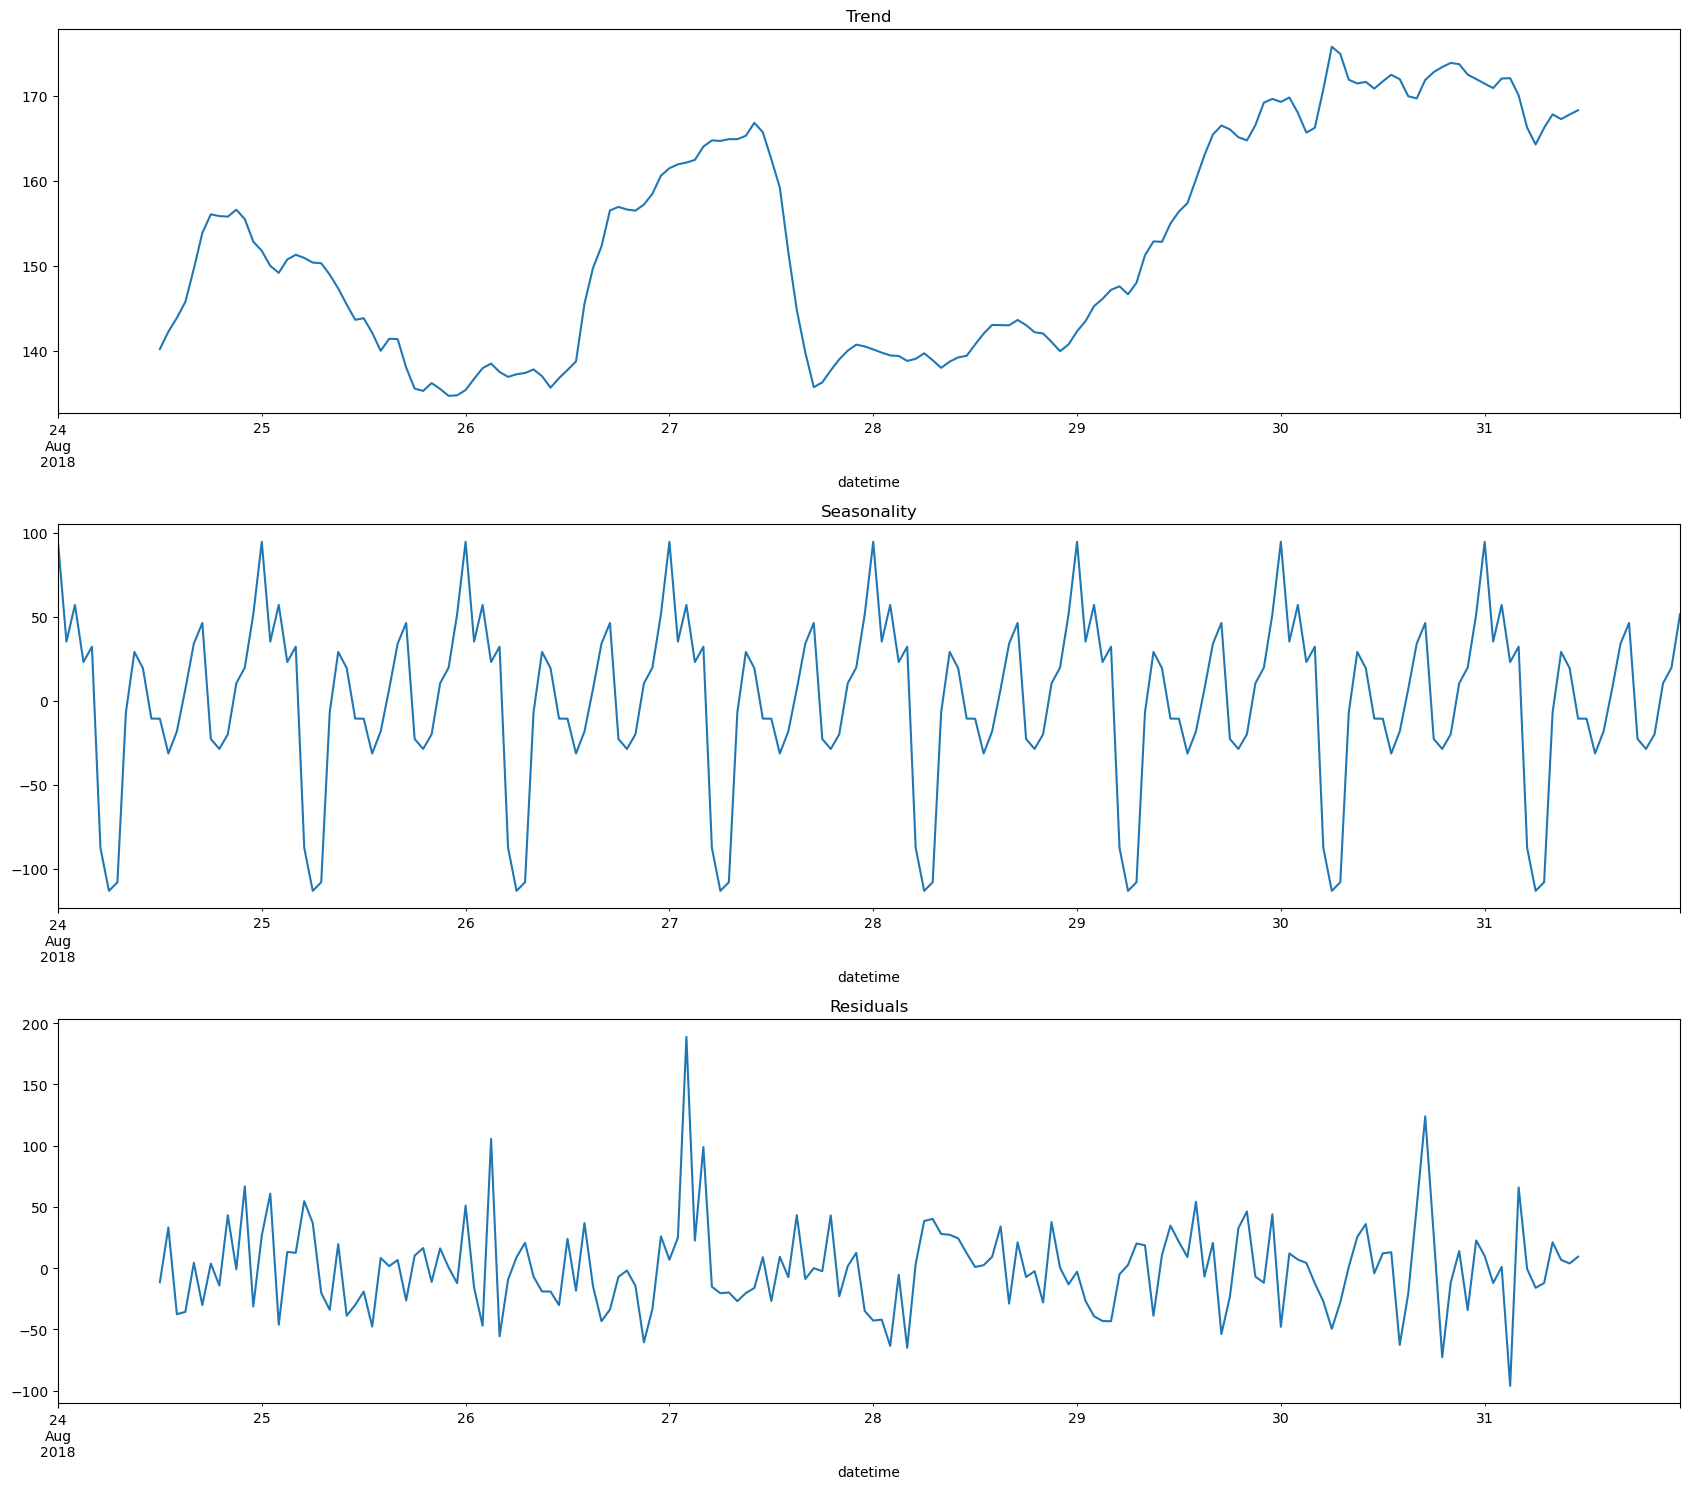

In [8]:
decomposed = seasonal_decompose(df['2018-08-24':'2018-08-31'])

plt.figure(figsize=(17, 15))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

Также имеется тренд к росту числа вызовов, показатели изменения сезонности указыват нам на то, что, вероятно, она имеет место в течение каждых суток. Посмотрим на аналогичный график в течение последних двух суток.

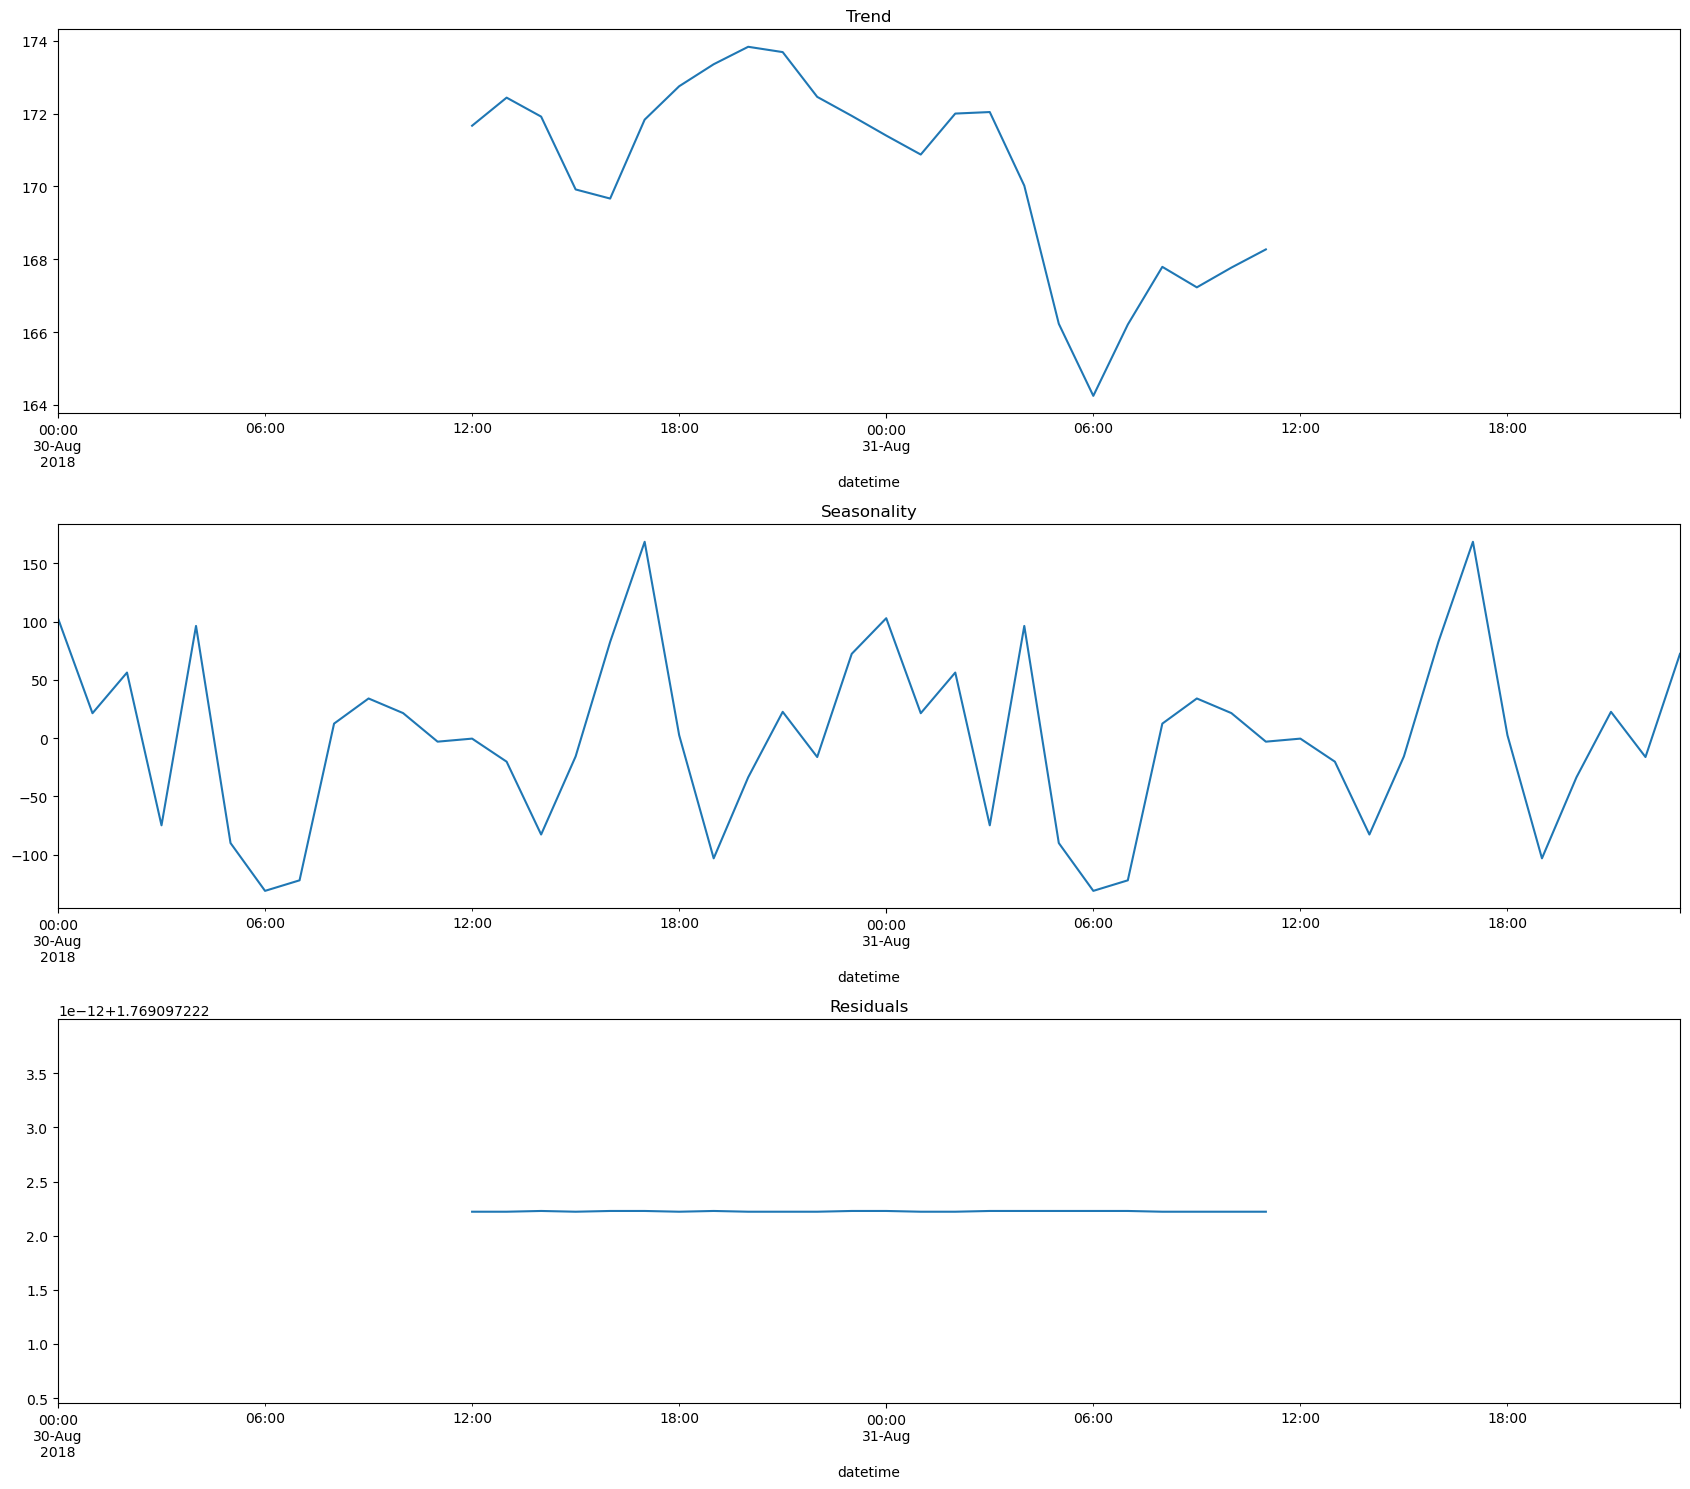

In [9]:
decomposed = seasonal_decompose(df['2018-08-30 00:00:00':'2018-08-31 23:00:00'])

plt.figure(figsize=(17, 15))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

За последние двое суток данные определили нам наличие тренда, причем в данном случае к снижению, а также наличие сезонности. Показатели шума не меняются.

Все изученные графики говорят нам о том, что нам понадобятся данные о месяце, неделе, дне, дне недели и часе. Показатели года в нашем случае не играют никакой роли, поскольку все данные на 2018 год. Также введем показатели разностей временного ряда и скользящего среднего.

In [10]:
df['week'] = df.index.week
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour

for lag in range(1, 31):
    df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

df['rolling_mean_6'] = df['num_orders'].shift().rolling(6).mean()
df['rolling_mean_12'] = df['num_orders'].shift().rolling(12).mean()
df['rolling_mean_30'] = df['num_orders'].shift().rolling(30).mean()

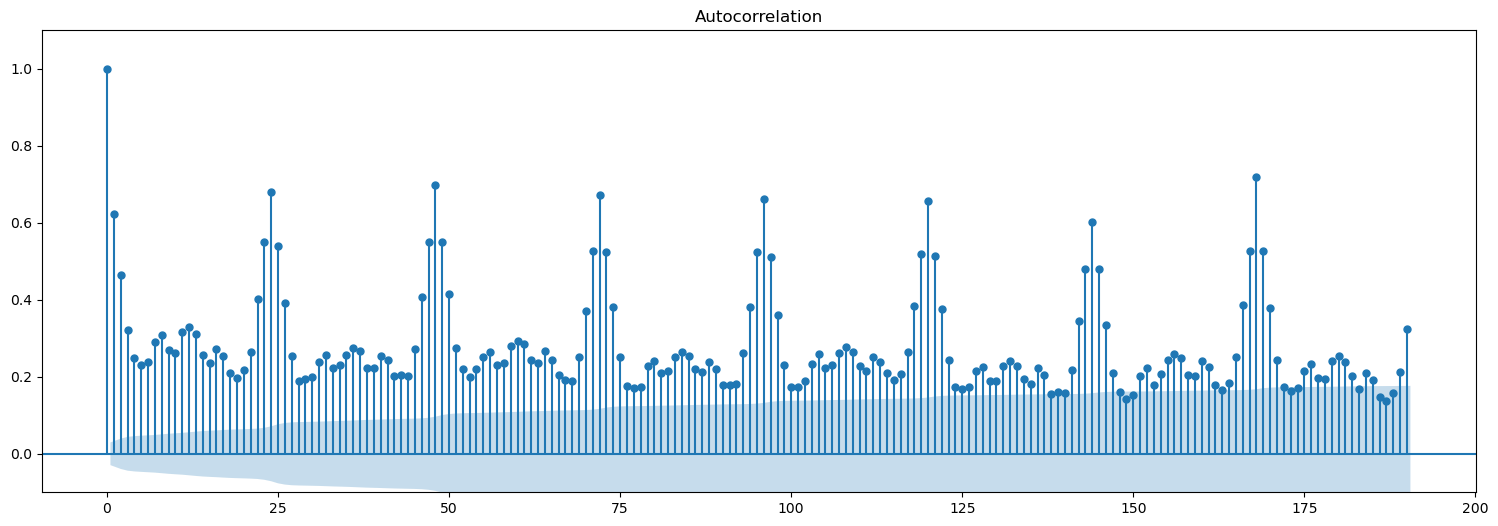

In [11]:
# Код ревьюера
from statsmodels.graphics import tsaplots

taxi = pd.read_csv("https://code.s3.yandex.net/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 



**Вывод:**

Проанализировав данные, мы пришл к выводу, что нам для достижения цели проекта понадобятся данные о месяце, неделе, дне, дне недели и часе. Также введены показатели разностей временного ряда и скользящего среднего.

## Обучение

Разобьем датасет на обучающую и тестовую выборки, также удалим из обучающей выборки данные с имеющимися там NaN-показателями, полученными в результате введения в датасет сведений о разностях временного ряда (заполнить их мы не можем).

In [12]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train.dropna(inplace=True)

Теперь разделим выборки на признаки и целевой признак.

In [13]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

Приступим к обучени моделей. Проверять метрику RMSE у них будем на кроссвалидации. Лидера впоследситвии проверим на тестовой выборке.

Посмотрим на показатели регрессии LinearRegression.

Для начала создадим функцию для выборки временных рядов через TimeSeriesSplit.

In [14]:
def cv_time_series_rmse(regressor, data, target_column, n_splits, max_train_size):
    tscv = TimeSeriesSplit(n_splits = n_splits, max_train_size = max_train_size)
    RMSE = 0.0
    for train_index, test_index in tscv.split(data):
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        train_features = train.drop(target_column, axis=1)
        train_target = train[target_column]
        test_features = test.drop(target_column, axis=1)
        test_target = test[target_column]
        regressor.fit(train_features, train_target)
        RMSE += mean_squared_error(test_target, regressor.predict(test_features)) ** 0.5
    return RMSE / n_splits

In [15]:
cv_train_test_split = (train.shape[0] * 4 //5)
cv_splits = 5

In [16]:
%%time

regressor = LinearRegression()
print('# Обучение модели и определение RMSE')
print()
cv_RMSE_LR = cv_time_series_rmse(regressor=regressor, 
                                 data=train, 
                                 target_column='num_orders', 
                                 n_splits=cv_splits, 
                                 max_train_size=cv_train_test_split)
print('Среднее RMSE на валидации LinearRegression =', cv_RMSE_LR)

# Обучение модели и определение RMSE

Среднее RMSE на валидации LinearRegression = 26.502848574338554
Wall time: 43 ms


Данная регрессия дала нам среднюю метрику около 26,5 на кроссвалидации. Неплохо, однако учитывая, что у нас отсутствует 10% датасета, которые по времени являются более актуальными и наличие тренда к увеличеию заказов такси, этого может быть недостаточно.

Далее проверим регрессию Ridge.

In [17]:
%%time

regressor = Ridge()
hyperparams = [{'alpha':[0.1, 1, 10, 100, 1000],
                'solver':['auto', 'svd', 'cholesky', 'lsqr','sparse_cg']}]


print('# Настройка параметров')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print("Лучшие параметры:")
print()
best_params_R = clf.best_params_
print(best_params_R)
print()
print("Сетка оценок:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

# Настройка параметров

Лучшие параметры:

{'alpha': 1000, 'solver': 'lsqr'}

Сетка оценок:

25.818559 for {'alpha': 0.1, 'solver': 'auto'}
25.818559 for {'alpha': 0.1, 'solver': 'svd'}
25.818559 for {'alpha': 0.1, 'solver': 'cholesky'}
25.805000 for {'alpha': 0.1, 'solver': 'lsqr'}
25.816819 for {'alpha': 0.1, 'solver': 'sparse_cg'}
25.818539 for {'alpha': 1, 'solver': 'auto'}
25.818539 for {'alpha': 1, 'solver': 'svd'}
25.818539 for {'alpha': 1, 'solver': 'cholesky'}
25.804983 for {'alpha': 1, 'solver': 'lsqr'}
25.816810 for {'alpha': 1, 'solver': 'sparse_cg'}
25.818343 for {'alpha': 10, 'solver': 'auto'}
25.818343 for {'alpha': 10, 'solver': 'svd'}
25.818343 for {'alpha': 10, 'solver': 'cholesky'}
25.804816 for {'alpha': 10, 'solver': 'lsqr'}
25.816630 for {'alpha': 10, 'solver': 'sparse_cg'}
25.816408 for {'alpha': 100, 'solver': 'auto'}
25.816408 for {'alpha': 100, 'solver': 'svd'}
25.816408 for {'alpha': 100, 'solver': 'cholesky'}
25.803162 for {'alpha': 100, 'solver': 'lsqr'}
25

In [18]:
%%time

regressor = Ridge()
regressor.set_params(**best_params_R)
print('# Обучение')
print()
cv_RMSE_R = cv_time_series_rmse(regressor=regressor, 
                                data=train, 
                                target_column='num_orders', 
                                n_splits=cv_splits, 
                                max_train_size=cv_train_test_split)
print('Среднее RMSE на валидации Ridge =', cv_RMSE_R)

# Обучение

Среднее RMSE на валидации Ridge = 26.579550966681865
Wall time: 54 ms


Данная регрессия также дала нам метрику около 26,5 на лучшем показателе. Но учитывая, что у нас отсутствует 10% датасета, которые по времени являются более актуальными и наличие тренда к увеличеию заказов такси, этого может быть недостаточно.

Далее посмотрим на метрики регрессии DecisionTreeRegressor.

In [19]:
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 21)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[3301]}]

print('# Настройка параметров')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print("Лучшие параметры:")
print()
best_params_DTR = clf.best_params_
print(best_params_DTR)
print()
print("Сетка оценок:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

# Настройка параметров

Лучшие параметры:

{'criterion': 'mse', 'max_depth': 5, 'random_state': 3301}

Сетка оценок:

31.057149 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 3301}
29.588369 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 3301}
28.705390 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 3301}
28.312915 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 3301}
28.716221 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 3301}
29.261142 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 3301}
29.792445 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 3301}
31.001543 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 3301}
32.093756 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 3301}
33.049183 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 3301}
32.958444 for {'criterion': 'mse', 'max_depth': 12, 'random_state': 3301}
33.298419 for {'criterion': 'mse', 'max_depth': 13, 'random_state': 3301}
33

In [20]:
%%time

regressor = DecisionTreeRegressor()
regressor.set_params(**best_params_DTR)
print('# Обучение')
print()
cv_RMSE_DTR = cv_time_series_rmse(regressor=regressor, 
                                  data=train, 
                                  target_column='num_orders', 
                                  n_splits=cv_splits, 
                                  max_train_size=cv_train_test_split)
print('Среднее RMSE на валидации DecisionTreeRegressor =', cv_RMSE_DTR)

# Обучение

Среднее RMSE на валидации DecisionTreeRegressor = 30.04224428583359
Wall time: 130 ms


Данная регрессия дала нам метрику RMSE около 30 на лучшем показателе глубины дерева 5. Но этого также может быть недостаточно.

Далее посмотрим на метрику регрессии CatBoostRegressor.

In [21]:
%%time

regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[x/10 for x in range(1, 6)],
                'random_state':[3301],
                'verbose':[False]}]

print('# Настройка параметров')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print("Лучшие параметры:")
print()
best_params_CBR = clf.best_params_
print(best_params_CBR)
print()
print("Сетка оценок:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

# Настройка параметров

Лучшие параметры:

{'learning_rate': 0.1, 'random_state': 3301, 'verbose': False}

Сетка оценок:

23.457892 for {'learning_rate': 0.1, 'random_state': 3301, 'verbose': False}
23.782643 for {'learning_rate': 0.2, 'random_state': 3301, 'verbose': False}
24.725254 for {'learning_rate': 0.3, 'random_state': 3301, 'verbose': False}
25.284143 for {'learning_rate': 0.4, 'random_state': 3301, 'verbose': False}
25.754038 for {'learning_rate': 0.5, 'random_state': 3301, 'verbose': False}

Wall time: 2min 34s


In [22]:
%%time

regressor = CatBoostRegressor()
regressor.set_params(**best_params_CBR)
print('# Обучение')
print()
cv_RMSE_CBR = cv_time_series_rmse(regressor=regressor, 
                                  data=train, 
                                  target_column='num_orders', 
                                  n_splits=cv_splits, 
                                  max_train_size=cv_train_test_split)
print('Среднее RMSE на валидации CatBoostRegressor =', cv_RMSE_CBR)

# Обучение

Среднее RMSE на валидации CatBoostRegressor = 24.233757669949846
Wall time: 30.5 s


Регрессия CatBoostRegressor дала нам метрику RMSE около 24, что уже существенно лучший показатель. Но давайте взглянем на метрики регрессии LGBMRegressor. 

In [23]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[31, 100, 200],
                'learning_rate':[x/10 for x in range(1, 6)],
                'random_state':[3301]}]

print('# Настройка параметров')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print("Лучшие параметры:")
print()
best_params_LGBMR = clf.best_params_
print(best_params_LGBMR)
print()
print("Сетка оценок:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

# Настройка параметров

Лучшие параметры:

{'learning_rate': 0.1, 'num_leaves': 31, 'random_state': 3301}

Сетка оценок:

23.545079 for {'learning_rate': 0.1, 'num_leaves': 31, 'random_state': 3301}
24.258814 for {'learning_rate': 0.1, 'num_leaves': 100, 'random_state': 3301}
24.400811 for {'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 3301}
24.239611 for {'learning_rate': 0.2, 'num_leaves': 31, 'random_state': 3301}
25.012464 for {'learning_rate': 0.2, 'num_leaves': 100, 'random_state': 3301}
25.031643 for {'learning_rate': 0.2, 'num_leaves': 200, 'random_state': 3301}
24.425845 for {'learning_rate': 0.3, 'num_leaves': 31, 'random_state': 3301}
25.540832 for {'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 3301}
25.361777 for {'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 3301}
26.275838 for {'learning_rate': 0.4, 'num_leaves': 31, 'random_state': 3301}
26.221677 for {'learning_rate': 0.4, 'num_leaves': 100, 'random_state': 3301}
26.131244 for {'learning

In [24]:
%%time

regressor = LGBMRegressor()
regressor.set_params(**best_params_LGBMR)
print('# Обучение')
print()
cv_RMSE_LGBMR = cv_time_series_rmse(regressor=regressor, 
                                    data=train, 
                                    target_column='num_orders', 
                                    n_splits=cv_splits, 
                                    max_train_size=cv_train_test_split)
print('Среднее RMSE на валидации LGBMRegressor =', cv_RMSE_LGBMR)

# Обучение

Среднее RMSE на валидации LGBMRegressor = 24.755888497971082
Wall time: 476 ms


Регрессия LGBMRegressor дала нам наименьшую метрику RMSE чуть более 24,5 на лучших параметрах `'learning_rate': 0.1` и `'num_leaves': 3`, однако наилучшим вариантом из рассмотренных моделей оказалась модель CatBoostRegressor, которая дала RMSE чуть менее 24,5.

**Вывод:**

Среди рассмотренны моделей регрессий CatBoostRegressor дала нам наименьшую метрику RMSE чуть менее 24,5 на лучших параметрах `'learning_rate': 0.1`, что явиется наилучшим вариантом из рассмотренных моделей. Полагаю ее необходимо протестировать на тестовой выборке, несмотря на то, что по прогнозам показатели там несомненно несколько ухудшатся.

## Тестирование

Итак, посмотрим на показатели метрики RMSE нашей лучшей модели с лучшими параметрами на тестовой выборке.

In [25]:
%%time

model = CatBoostRegressor(learning_rate=0.1, random_state=3301, verbose=False)

model.fit(features_train, target_train)

target_predict = model.predict(features_test)

control_RMSE = mean_squared_error(target_test, target_predict) ** 0.5
control_RMSE

Wall time: 7.84 s


39.78385259174618

Как мы видим, показатели метрики RMSE действительно несколько ухудшились и составляют *39.78385259174618*, что подходит по условиям проекта, следовательно, цель достигнута. 

Давайте проверим модель на адекватность и применим варианты с медианой и средним имеющегося в обучающей выборке признака `'num_orders'`. 

In [26]:
predict_median = target_test.shape[0] * [target_train.median()]
predict_mean = target_test.shape[0] * [target_train.mean()]
RMSE_median = mean_squared_error(target_test, predict_median) ** 0.5
RMSE_mean = mean_squared_error(target_test, predict_mean) ** 0.5
RMSE_median, RMSE_mean

(87.15277582981295, 84.63336276399527)

In [27]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
RMSE_const = mean_squared_error(target_test, pred_previous) ** 0.5
RMSE_const

58.856486242815066

Как мы видим, наша модель дает примерно в 2 раза лучший показатель RMSE, чем модель по медиане и среднему и примерно в 1,5 раза лучше, чем модель по константе.

**Вывод:**

Мы получили модель CatBoostRegressor с метрикой RMSE на тестовой выборке *39.78385259174618*, что подходит по условиям проекта и отвечает требованиям адекватности. 

## Общие выводы:


В ходе работы над проектом мы загрузили данные, выполнили их ресемплирование по одному часу, провели их анализ, обучили разные модели с различными гиперпараметрами, сделали тестовую выборку размером 10% от исходных данных, проверили лучшую модель на тестовой выборке.

Мы получили модель CatBoostRegressor с метрикой RMSE на тестовой выборке *39.78385259174618*, что подходит по условиям проекта, следовательно, цель достигнута. 